# Mutual information statistics 
### The information computed here is presented in the _Methods and Materials_ chapter, as well as under the second (_Waveform-based and spike-timing features allow near-perfect classification of PYR and PV cells_) and third (_Transforming multi-channel spike waveforms to event-based delta-like functions removes all waveform-based information and allows extracting purely spatial features_) subsections of the _Results_. It is also presented in the Extended Data Figures 2-1, 2-2, and 3-1.
#### Note that the mutual information (MI) values as well as _p-values_ for each MI value are computed outside of this notebook in Matlab using the script ./matlab files/features_MI.mat (see paper for required packages). The output of this script, _MIs.mat_ is availavle in the current directory and is assumed to be computed before execution of the notebook.

In [1]:
from notebooks_constants import SRC_PATH
import sys
sys.path.insert(0, SRC_PATH)

import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.io as io

import matplotlib.pyplot as plt
import seaborn as sns

from constants import SPATIAL, SPIKE_TIMING, WAVEFORM
from constants import feature_names_org as feature_names
from paths import MI_MAT
from perm_test import calc_perm_test

In [2]:
mod_d = {'spatial': SPATIAL[:-1], 'spike-timing': SPIKE_TIMING[:-1], 'waveform': WAVEFORM[:-1],
         'modalities': SPATIAL[:-1] + SPIKE_TIMING[:-1] + WAVEFORM[:-1]}

modality_families = {'spatial': [feature_names[i] for i in SPATIAL[:-1]],
                     'spike-timing': [feature_names[i] for i in SPIKE_TIMING[:-1]],
                     'waveform': [feature_names[i] for i in WAVEFORM[:-1]]}

In [3]:
families_d = {'modalities': modality_families}

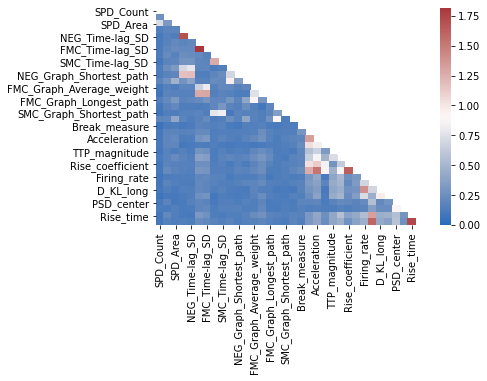

In [4]:
column_values = feature_names
mi_mat = io.loadmat(MI_MAT)['mis']
mi_mat = pd.DataFrame(data = mi_mat, 
                  index = column_values, 
                  columns = column_values)

mask = np.triu(np.ones_like(mi_mat, dtype=bool))
plt.yticks(rotation=30)
cmap = sns.color_palette("vlag", as_cmap=True)
vmax = mi_mat.to_numpy()[~mask].max()
_ = sns.heatmap(mi_mat, annot=False, fmt='.2f', mask=mask, vmin=0, vmax=vmax, cmap=cmap,
                    annot_kws={"fontsize": 1})

plt.show()

In [5]:
for mod in mod_d:
    if mod != 'modalities':
        continue
    print(mod)
    
    mod_mat = mi_mat.loc[[feature_names[i] for i in mod_d[mod]], [feature_names[i] for i in mod_d[mod]]]
    mod_np = mod_mat.to_numpy()
    mask = np.triu(np.ones_like(mod_np, dtype=bool))
    mod_np = mod_np[~mask]
    print(f'    median (IQR) MI: {np.median(mod_np): .3f} ({np.quantile(mod_np, 0.25): .3f}, {np.quantile(mod_np, 0.75): .3f})')
    print()
    
    for fam in families_d[mod]:
        fam_mat = mod_mat.loc[families_d[mod][fam], families_d[mod][fam]].to_numpy()
        mask = np.triu(np.ones_like(fam_mat, dtype=bool))
        fam_mat = fam_mat[~mask].flatten()
        if len(fam_mat) > 0:
            print(f'    median (IQR) MI of {fam}: {np.median(fam_mat): .3f} ({np.quantile(fam_mat, 0.25): .3f}, {np.quantile(fam_mat, 0.75): .3f})')
        else:
            print(f'    median (IQR) MI of {fam}: None (None None)')        
    print()
        
    for i, fam1 in enumerate(families_d[mod]):
        for j, fam2 in enumerate(families_d[mod]):
            if i >= j:
                continue
            cross_mat = mod_mat.loc[families_d[mod][fam1], families_d[mod][fam2]].to_numpy().flatten()
            print(f'    median (IQR) MI of {fam1} X {fam2}: {np.median(cross_mat): .3f} ({np.quantile(cross_mat, 0.25): .3f}, {np.quantile(cross_mat, 0.75): .3f})')    
    print()

modalities
    median (IQR) MI:  0.173 ( 0.140,  0.250)

    median (IQR) MI of spatial:  0.190 ( 0.155,  0.266)
    median (IQR) MI of spike-timing:  0.469 ( 0.283,  0.701)
    median (IQR) MI of waveform:  0.658 ( 0.292,  0.955)

    median (IQR) MI of spatial X spike-timing:  0.147 ( 0.127,  0.170)
    median (IQR) MI of spatial X waveform:  0.156 ( 0.131,  0.185)
    median (IQR) MI of spike-timing X waveform:  0.267 ( 0.171,  0.387)



In [6]:
wf_mat = mi_mat.loc[[feature_names[i] for i in mod_d['waveform']],[feature_names[i] for i in mod_d['waveform']]]
wf_np = wf_mat.to_numpy()
mask_wf = np.triu(np.ones_like(wf_np, dtype=bool))
wf_np = wf_np[~mask_wf]

st_mat = mi_mat.loc[[feature_names[i] for i in mod_d['spike-timing']],[feature_names[i] for i in mod_d['spike-timing']]]
st_np = st_mat.to_numpy()
mask_st = np.triu(np.ones_like(st_np, dtype=bool))
st_np = st_np[~mask_st]

spat_mat = mi_mat.loc[[feature_names[i] for i in mod_d['spatial']],[feature_names[i] for i in mod_d['spatial']]]
spat_np = spat_mat.to_numpy()
mask_spat = np.triu(np.ones_like(spat_np, dtype=bool))
spat_np = spat_np[~mask_spat]

print('MI differences between modalities')
print(f'Spatial vs.Spike-timing p-value={stats.mannwhitneyu(st_np, spat_np)}')
print(f'Spatial vs. Waveform p-value={stats.mannwhitneyu(wf_np, spat_np)}')


MI differences between modalities
Spatial vs.Spike-timing p-value=MannwhitneyuResult(statistic=674.0, pvalue=4.27703843713745e-09)
Spatial vs. Waveform p-value=MannwhitneyuResult(statistic=696.0, pvalue=7.104465706617027e-09)
